In [1]:
import torch
import numpy as np
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import random
import torch.nn as nn
import torch.optim as optim
import heapq
import os

In [2]:
torch.cuda.is_available()

True

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

Using device: cuda


In [4]:
# For reproducibility
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

## Generate dataset using the second derivative instead of the first

The code currently loads a previously created dataset instead of creating a new one each time.

In [5]:
class FourierSeriesDataset(Dataset):
    def __init__(self, num_samples, num_points, max_terms=10):
        self.num_samples = num_samples
        self.num_points = num_points
        self.max_terms = max_terms
        self.x = torch.linspace(0, 2*np.pi, num_points, requires_grad=True)
        self.functions, self.first_derivatives, self.second_derivatives = self.generate_data()

    def generate_data(self):
        functions = []
        first_derivatives = []
        second_derivatives = []

        for _ in range(self.num_samples):
            # Generate random complex coefficients
            n_terms = np.random.randint(1, self.max_terms + 1)
            c = torch.complex(torch.randn(2*n_terms+1), torch.randn(2*n_terms+1))

            # Compute function values
            y = self.complex_fourier_series(self.x, c)
            functions.append(y.detach().numpy())

            # Compute derivative
            dy_dx = torch.autograd.grad(y, self.x, grad_outputs=torch.ones_like(y), create_graph=True)[0]
            first_derivatives.append(dy_dx.detach().numpy())

            d2y_dx2 = torch.autograd.grad(outputs=dy_dx, inputs=self.x, grad_outputs=torch.ones_like(dy_dx), create_graph=True)[0]
            second_derivatives.append(d2y_dx2.detach().numpy())

        return np.array(functions), np.array(first_derivatives), np.array(second_derivatives)

    def complex_fourier_series(self, x, c, P=2*np.pi):
        result = torch.zeros_like(x, dtype=torch.complex64)
        n_terms = (len(c) - 1) // 2
        for n in range(-n_terms, n_terms+1):
            result += c[n + len(c)//2] * torch.exp(1j * 2 * np.pi * n * x / P)
        return result.real

    def __len__(self):
        return self.num_samples

    def __getitem__(self, idx):
        return torch.FloatTensor(self.functions[idx]), torch.FloatTensor(self.first_derivatives[idx]), torch.FloatTensor(self.second_derivatives[idx])

# Generate dataset
num_samples = 10000
num_points = 1000
dataset = FourierSeriesDataset(num_samples, num_points)

# Create DataLoader
batch_size = 32
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
torch.save(dataset, 'datasets/both_derivatives_dataset.pt')

## Load previously saved dataset

In [6]:
# dataset = torch.load('derivative_dataset.pt')
# to use the cluster dataset, use:
# dataset = torch.load('datasets/second_derivative_dataset.pt')

In [7]:
from torch.utils.data import random_split
total_size = len(dataset)
train_size = int(0.8 * total_size)
test_size = total_size - train_size
generator = torch.Generator().manual_seed(seed)
train_dataset, test_dataset = random_split(dataset, [train_size, test_size], generator=generator)

In [8]:
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True, drop_last=True)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False, drop_last=True)

In [9]:
print(len(train_dataloader))
print(len(test_dataloader))

250
62


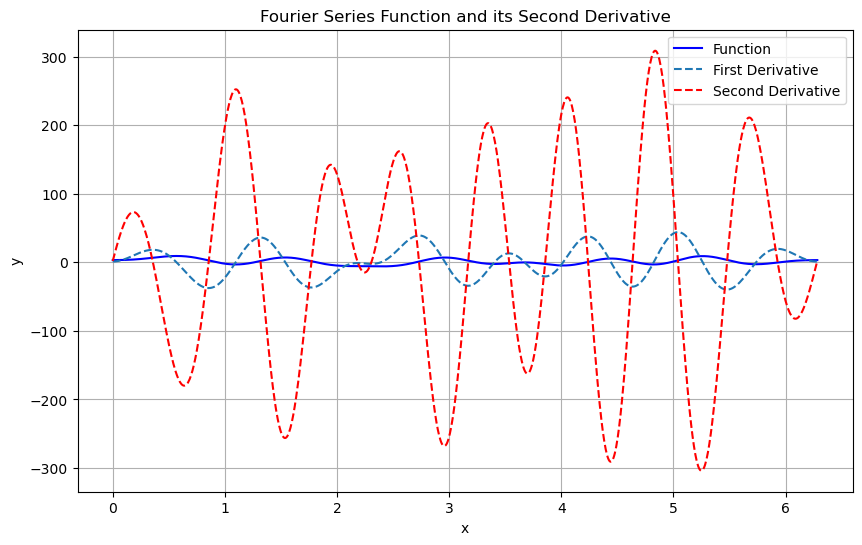

In [15]:
def plot_function_and_derivative(dataloader):
    # Get a single sample from the dataloader
    dataiter = iter(dataloader)
    function, derivative, second_derivative = next(dataiter)

    # Since we're dealing with batches, let's take the first item in the batch
    function = function[0].numpy()
    derivative = derivative[0].numpy()
    second_derivative = second_derivative[0].numpy()

    # Create x-axis values (assuming the domain is [0, 2π])
    x = torch.linspace(0, 2*torch.pi, len(function)).numpy()

    # Create the plot
    plt.figure(figsize=(10, 6))
    plt.plot(x, function, label='Function', color='blue')
    plt.plot(x, derivative, label='First Derivative', linestyle='--')
    plt.plot(x, second_derivative, label='Second Derivative', color='red', linestyle='--')
    
    plt.title('Fourier Series Function and its Second Derivative')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.legend()
    plt.grid(True)
    
    plt.show()

# Example usage:
# Assuming you have already created your dataset and dataloader as before
# dataset = FourierSeriesDataset(num_samples, num_points)

def get_random_function(shuffle=True):
    return DataLoader(train_dataset, batch_size=1, shuffle=shuffle)

train_dataloader_viz = get_random_function(shuffle=False)
plot_function_and_derivative(train_dataloader_viz)

## Model Training

Create the model

In [16]:
# simple 1D CNN
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv1d(1, 64, kernel_size=3, padding=1)
        self.conv2 = nn.Conv1d(64, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv1d(64, 1, kernel_size=3, padding=1)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        x = self.conv3(x)
        return x

# Initialize the model, loss function, and optimizer
model1 = SimpleCNN()
criterion = nn.MSELoss()
optimizer = optim.Adam(model1.parameters())

## Load in previously saved model weights from 300 epochs

In [ ]:
# model1.load_state_dict(torch.load('model_weights.pth'))
# to use model from cluster, change this to 
# model1.load_state_dict(torch.load('models/first_stage_1000epochs_second_derivative_weights.pth'))


<All keys matched successfully>

## Training loop

In [31]:
# Training loop
train_losses = []
test_losses = []

def first_stage_training(num_epochs):
    for epoch in range(num_epochs):
        model1.train()
        train_loss = 0.0
        test_loss = 0.0

        for batch_functions, batch_derivatives, _ in train_dataloader:
            # Reshape input: [batch_size, 1, num_points]
            batch_functions = batch_functions.unsqueeze(1)
            batch_derivatives = batch_derivatives.unsqueeze(1)

            # Forward pass
            outputs = model1(batch_functions)
            loss = criterion(outputs, batch_derivatives)

            # Backward pass and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        train_loss /= len(train_dataloader)

        model1.eval()
        with torch.no_grad():
            for b_test_functions, b_test_derivatives, _ in test_dataloader:
                b_test_functions = b_test_functions.unsqueeze(1)
                b_test_derivatives = b_test_derivatives.unsqueeze(1)

                test_outputs = model1(b_test_functions)
                batch_test_loss = criterion(test_outputs, b_test_derivatives)

                test_loss += batch_test_loss.item()

        test_loss /= len(test_dataloader)

        train_losses.append(train_loss)
        test_losses.append(test_loss)

        print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}')
    
    print("Training finished!")


# Save the model
# Don't save the model right now

first_stage_training(1000)
torch.save(model1.state_dict(), 'models/first_stage_1000epochs_first_derivative_weights.pth')

Epoch [1/20], Train Loss: 0.9510, Test Loss: 0.9916
Epoch [2/20], Train Loss: 0.7155, Test Loss: 0.6806
Epoch [3/20], Train Loss: 0.7095, Test Loss: 0.5472
Epoch [4/20], Train Loss: 0.5336, Test Loss: 0.4837
Epoch [5/20], Train Loss: 0.5033, Test Loss: 0.4468
Epoch [6/20], Train Loss: 0.3980, Test Loss: 0.3839
Epoch [7/20], Train Loss: 0.5401, Test Loss: 0.5669
Epoch [8/20], Train Loss: 0.3342, Test Loss: 0.3462
Epoch [9/20], Train Loss: 0.2999, Test Loss: 0.3646
Epoch [10/20], Train Loss: 0.3322, Test Loss: 0.2630
Epoch [11/20], Train Loss: 0.2819, Test Loss: 0.4786
Epoch [12/20], Train Loss: 0.3535, Test Loss: 0.2343
Epoch [13/20], Train Loss: 0.2643, Test Loss: 0.2204
Epoch [14/20], Train Loss: 0.2360, Test Loss: 0.2192
Epoch [15/20], Train Loss: 0.2669, Test Loss: 0.5041
Epoch [16/20], Train Loss: 0.3198, Test Loss: 0.1705
Epoch [17/20], Train Loss: 0.1980, Test Loss: 0.6043
Epoch [18/20], Train Loss: 0.2197, Test Loss: 0.1941
Epoch [19/20], Train Loss: 0.2051, Test Loss: 0.1583
Ep

In [32]:
def plot_losses(train_losses, test_losses, save_dir='plots', xmin=None, ymax=None, filename=None):
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)
    epochs = range(1, len(train_losses) + 1)
    plt.figure(figsize=(10, 5))
    plt.plot(epochs, train_losses, linestyle='-', color='b', label='Training Loss')
    plt.plot(epochs, test_losses, linestyle='-', label='Test Loss')
    plt.title('Loss over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    # if xmin:
    #     plt.xlim(xmin=xmin)
    #     min_loss = min(min(train_losses[xmin-1:]), min(test_losses[xmin-1:]))
    #     max_loss = max(max(train_losses[xmin-1:]), max(test_losses[xmin-1:]))
    #     plt.ylim(min_loss, max_loss)
    # if ymax:
    #     plt.ylim(ymax=ymax)
    plt.yscale('log')  # Set the y-axis to logarithmic scale
    plt.legend()
    plt.grid(True)
    save_path = os.path.join(save_dir, filename)
    plt.savefig(save_path)    
    plt.show()

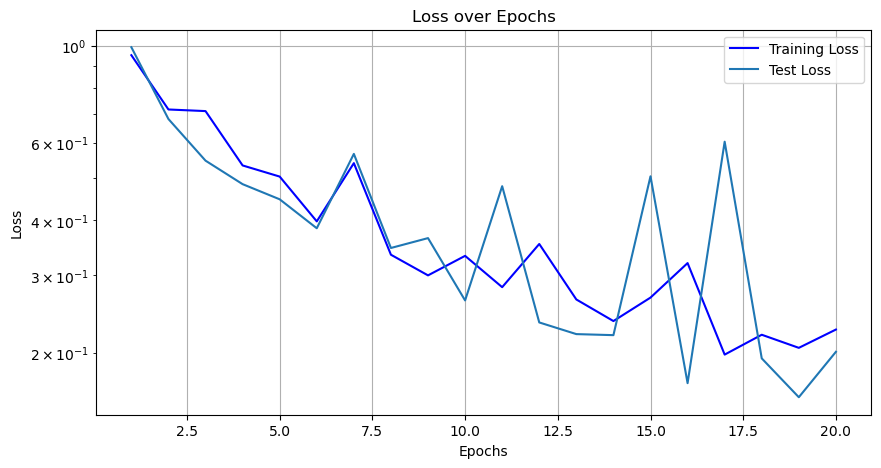

In [33]:
plot_losses(train_losses=train_losses, test_losses=test_losses, filename='first_stage_first_derivative_loss')

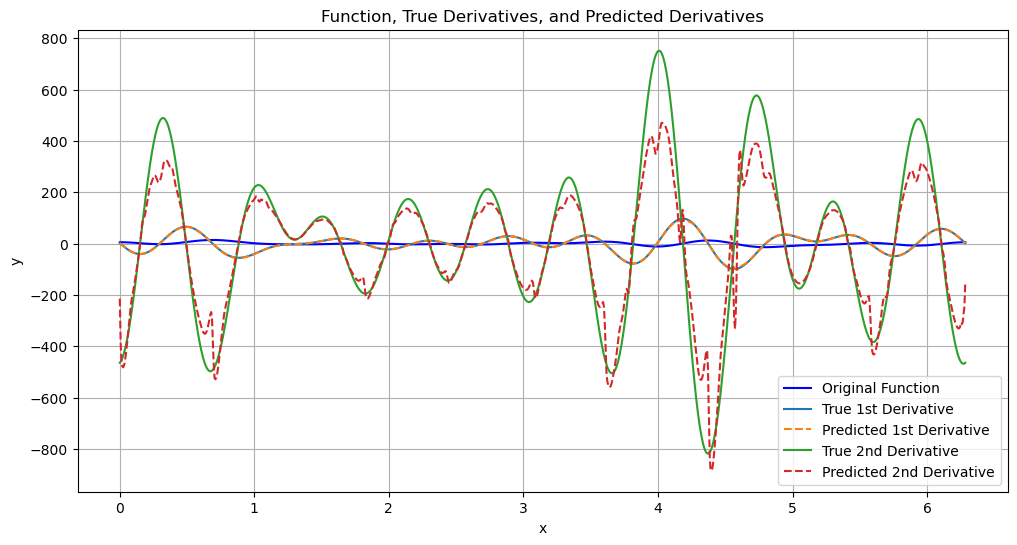

In [37]:
model1.eval()  # Set the model to evaluation mode

train_dataloader_viz = get_random_function(shuffle=True)
# Get a random sample from the dataloader
dataiter = iter(train_dataloader_viz)
function, true_derivative, true_second_derivative = next(dataiter)

# Reshape the input for the model
function = function.unsqueeze(1)  # Add channel dimension

# Make prediction
with torch.no_grad():
    predicted_derivative = model1(function)
    predicted_second_derivative = model1(predicted_derivative)

# Convert tensors to numpy arrays for plotting
x = torch.linspace(0, 2*torch.pi, 1000).numpy()
function = function.squeeze().numpy()
true_derivative = true_derivative.squeeze().numpy()
predicted_derivative = predicted_derivative.squeeze().numpy()

true_second_derivative = true_second_derivative.squeeze().numpy()
predicted_second_derivative = predicted_second_derivative.squeeze().numpy()

# Plot the results
plt.figure(figsize=(12, 6))
plt.plot(x, function, label='Original Function', color='blue')
plt.plot(x, true_derivative, label='True 1st Derivative')
plt.plot(x, predicted_derivative, label='Predicted 1st Derivative', linestyle='--')
plt.plot(x, true_second_derivative, label='True 2nd Derivative')
plt.plot(x, predicted_second_derivative, label='Predicted 2nd Derivative', linestyle='--')

plt.title('Function, True Derivatives, and Predicted Derivatives')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.grid(True)
plt.show()

In [38]:
smallest_five = heapq.nsmallest(5, test_losses)
smallest_five

[0.15834883780729386,
 0.17046750384953716,
 0.19410486831780402,
 0.20089202242032175,
 0.2192332352842054]

## Calculate accuracy (MSE)

In [72]:
import torch

def compute_mse(dataloader, model1, model2=None):
    model1.eval()

    mse_accumulator = 0.0
    n_batches = 0

    # Inspect the first batch to determine the number of elements
    first_batch = next(iter(dataloader))
    num_elements = len(first_batch)
    
    print(f"Number of elements in each batch: {num_elements}")

    for batch in dataloader:
        if num_elements == 2:
            x, y = batch
        elif num_elements == 3:
            x, y, _ = batch
        else:
            raise ValueError(f"Unexpected number of elements in batch: {num_elements}")

        x = x.unsqueeze(1)
        y = y.unsqueeze(1)
        if model2:
            model_output = calculate_combined_output(model1, model2, x, y)
        else:
            model_output = model1(x)
        mse = torch.mean((model_output - y) ** 2, dim=2) 
        mse_accumulator += mse.mean().item()  
        n_batches += 1

    overall_mse = mse_accumulator / n_batches
    print(f"Overall MSE over all test functions: {overall_mse}")
    return overall_mse
compute_mse(test_dataloader, model1)

Number of elements in each batch: 3
Overall MSE over all test functions: 0.20089202422288158


0.20089202422288158

MSE for second stage is much higher than I expect

In [73]:
compute_mse(test_dataloader, model1)

Number of elements in each batch: 3
Overall MSE over all test functions: 0.20089202422288158


0.20089202422288158

## Spectral biases from Fourier Transform

In [74]:
# Get the output of the trained model
model1.eval()
with torch.no_grad():
    for x, y, _ in train_dataloader:
        x = x.unsqueeze(1)
        y = y.unsqueeze(1)
        output = model1(x)
        break  # Use the first batch for simplicity

# Compute the Fourier transform of the output
output_np = output.numpy().squeeze(1)
output_fft = np.fft.fft(output_np, axis=1)

# Compute the Fourier transform of the true function
y_np = y.numpy().squeeze(1)
y_fft = np.fft.fft(y_np, axis=1)

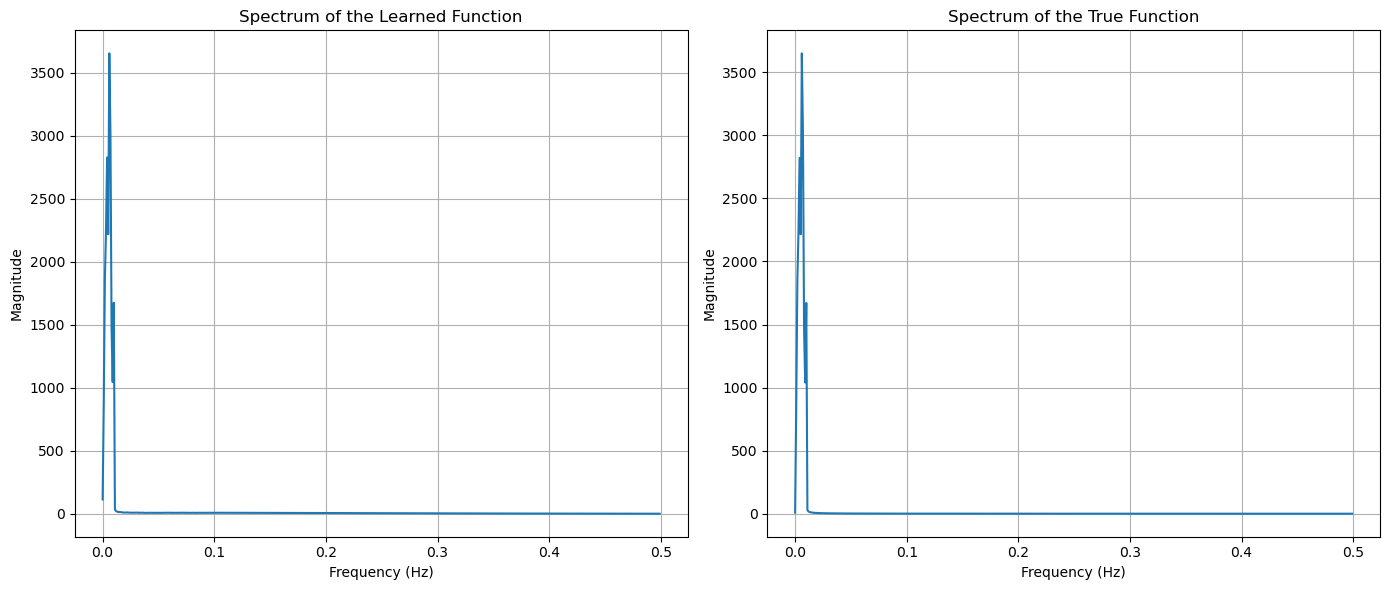

In [75]:
# Squeeze out unnecessary dimensions
output_np = output_np
y_np = y_np

# Compute the Fourier transform of the outputs
output_fft = np.fft.fft(output_np, axis=1)
y_fft = np.fft.fft(y_np, axis=1)

# Compute the magnitude of the FFT and average over all samples
output_fft_magnitude = np.abs(output_fft).mean(axis=0)
y_fft_magnitude = np.abs(y_fft).mean(axis=0)

# Calculate the frequency bins
num_samples = output_np.shape[-1]
frequency_bins = np.fft.fftfreq(num_samples, d=1.0)  # Assuming unit sampling rate for simplicity

# Only take the first half of the frequency bins and magnitude spectrum due to symmetry in FFT of real signals
half_index = num_samples // 2
frequency_bins = frequency_bins[:half_index]
output_fft_magnitude = output_fft_magnitude[:half_index]
y_fft_magnitude = y_fft_magnitude[:half_index]

# Plotting
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
plt.title('Spectrum of the Learned Function')
plt.plot(frequency_bins, output_fft_magnitude)
plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitude')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.title('Spectrum of the True Function')
plt.plot(frequency_bins, y_fft_magnitude)
plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitude')
plt.grid(True)

plt.tight_layout()
plt.show()

In [76]:
def categorize_functions(dataloader, threshold):
    low_freq_functions = []
    high_freq_functions = []

    # Iterate over batches in the dataloader
    for functions, derivatives, _ in dataloader:
        for idx, function in enumerate(functions):
            fft_coeffs = np.fft.fft(function.numpy())
            low_freq_magnitude = np.sum(np.abs(fft_coeffs[:threshold]))
            high_freq_magnitude = np.sum(np.abs(fft_coeffs[threshold:]))

            if low_freq_magnitude > high_freq_magnitude:
                low_freq_functions.append((function.numpy(), derivatives[idx].numpy()))
            else:
                high_freq_functions.append((function.numpy(), derivatives[idx].numpy()))

    return DataLoader(low_freq_functions), DataLoader(high_freq_functions)

In [77]:
low_freq_dataset, high_freq_dataset = categorize_functions(test_dataloader, 6)

print(f"Low frequency dataset size: {len(low_freq_dataset)}")
print(f"High frequency dataset size: {len(high_freq_dataset)}")

Low frequency dataset size: 1000
High frequency dataset size: 984


In [78]:
low_freq_mse = compute_mse(low_freq_dataset, model1)

Number of elements in each batch: 2
Overall MSE over all test functions: 0.08825021518813446


In [79]:
high_freq_mse = compute_mse(high_freq_dataset, model1)

Number of elements in each batch: 2
Overall MSE over all test functions: 0.31536551708605415
